In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/hw2

/content/drive/MyDrive/hw2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords

In [4]:
# Read the input text file into a DataFrame
df = pd.read_csv('data.txt')
df = df.sample(frac=1)

In [5]:
df = df.drop(columns=['Unnamed: 0'])

no_neutral = True

df = df.rename(columns={'text':'review', 'stars':'sentiment'})

if no_neutral:
    df = df[df['sentiment']!=3]
    df['sentiment'] = df['sentiment'].apply(lambda x: int(x>3))
else:
    df['sentiment'] = df['sentiment'].apply(lambda x: np.sign(x-3)+1)

In [6]:
from tensorflow.keras.utils import to_categorical

label = df.sentiment
label.unique()
num_classes = len(set(label))
one_hot_labels = to_categorical(label, num_classes=num_classes)

In [7]:
from gensim.parsing.porter import PorterStemmer
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
porter_stemmer = PorterStemmer()
review = df.review.values
review = [simple_preprocess(line, deacc=True) for line in review] 
review = [[porter_stemmer.stem(word) for word in tokens] for tokens in review]
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(review)
sequences = tokenizer.texts_to_sequences(review)

In [8]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

22393

In [9]:
maxlen = 200
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

In [10]:
from sklearn.model_selection import train_test_split
#split data into training and testing
padded_sequences, test_padded_sequences = train_test_split(padded_sequences, test_size=0.2, shuffle=False)
one_hot_labels, test_one_hot_labels = train_test_split(one_hot_labels, test_size=0.2, shuffle=False)

In [13]:
print(padded_sequences[0])

[  55  546  116   14   20    3  109 1165  573   26  371    5  258  174
   37   62    1  862 4135   59   72   16   15  573   24 1942 1165    4
  568   23  109   18  264 1723    8   12  920    2  454   18   20  519
    2  497  680  177    4   67   10   45 1856    2   77 1025   67  129
   78 1723  354    4  416   17  463    1  200    4  243 1321   32  101
   32   12  480   55 1165  573    9   67   45  259   18  321   18 2112
 1894   18    1  109   72  789    1  520   13   14   46 1295  646    2
   54 4262 1518 3308    1   46    6  204  322    7  196  210   41   15
  303   40   96    3   46  906 1448  322    3   96    3   25 1631    1
  204  388    6    1  220  138    5 1632    3  217   12  164   24  643
 1079  139    1  214  340  567   12  133  332   95    1  330   21    3
   81    7  367  539  148   18   36   16    1  224  489    5   45   18
  235    5   19  744   38  152  354    2    1  433    9 1109    5   10
  522  235    6 1332 2800   63   67    9   45 1014    6   35  180    4
  143 

In [14]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

num_classes = len(label.unique())
window_sizes = [2, 3, 4, 5]
num_filters = 10
architecture = "LSTM"
activation = "tanh"

if architecture == "LSTM":
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=30, input_length=maxlen))
    model.add(SpatialDropout1D(0.25))
    model.add(LSTM(64, activation=activation, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
else:
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=30, input_length=maxlen))
    model.add(SpatialDropout1D(0.25))
    model.add(Conv1D(num_filters, kernel_size=window_sizes[0], activation=activation))
    model.add(MaxPooling1D())
    for window_size in window_sizes[1:]:
        model.add(Conv1D(num_filters, kernel_size=window_size, activation=activation))
        model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 30)           671790    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 30)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                24320     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 696,240
Trainable params: 696,240
Non-trainable params: 0
__________________________________________________

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(padded_sequences,one_hot_labels,validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
400/400 [==============================] - 216s 521ms/step - loss: 0.3963 - accuracy: 0.8088 - val_loss: 0.2202 - val_accuracy: 0.9200
Epoch 2/20
400/400 [==============================] - 183s 458ms/step - loss: 0.2018 - accuracy: 0.9245 - val_loss: 0.2143 - val_accuracy: 0.9234
Epoch 3/20
400/400 [==============================] - 179s 447ms/step - loss: 0.1640 - accuracy: 0.9412 - val_loss: 0.1967 - val_accuracy: 0.9234
Epoch 4/20
400/400 [==============================] - 175s 439ms/step - loss: 0.1416 - accuracy: 0.9488 - val_loss: 0.2174 - val_accuracy: 0.9231
Epoch 5/20
400/400 [==============================] - 169s 422ms/step - loss: 0.1201 - accuracy: 0.9574 - val_loss: 0.1979 - val_accuracy: 0.9303
Epoch 6/20
400/400 [==============================] - 174s 435ms/step - loss: 0.1103 - accuracy: 0.9625 - val_loss: 0.3145 - val_accuracy: 0.9144


In [16]:
model.save('lstm_tanh.h5')

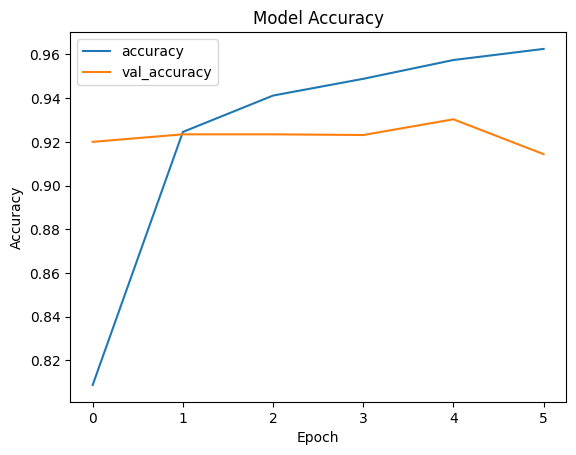

In [17]:
# Plot training and validation accuracy scores
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

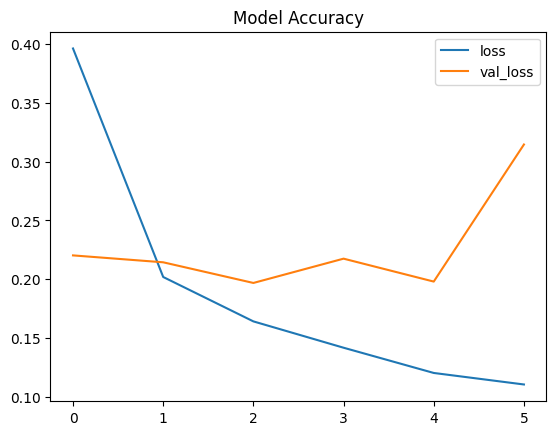

In [18]:
# Plot training and validation accuracy scores
plt.plot(history.history['loss'], label ='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [19]:
loss, accuracy = model.evaluate(test_padded_sequences, test_one_hot_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

125/125 [==============================] - 8s 60ms/step - loss: 0.3369 - accuracy: 0.9055
Accuracy: 90.55%


In [20]:
from sklearn.metrics import classification_report

# Make predictions using the trained model
y_pred = model.predict(test_padded_sequences)

# Convert the predictions from probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(np.argmax(test_one_hot_labels, axis=1), y_pred))

125/125 [==============================] - 8s 60ms/step
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2004
           1       0.94      0.86      0.90      1996

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

